In [68]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [3]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [5]:
df.shape

(8147, 13)

In [6]:
y.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: partner, dtype: float64

In [10]:
X.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1,0,0,0,0,0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1,0,0,0,0,0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,0,0,0,0,0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1,0,0,0,0,0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1,0,0,0,0,0


Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [11]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

In [12]:
clf.feature_importances_

array([1.96155330e-03, 2.18525634e-02, 1.02130794e-02, 1.22691960e-02,
       8.87972320e-03, 1.19033247e-01, 3.02936288e-02, 9.97741726e-03,
       3.68919406e-02, 7.21467795e-01, 2.54943268e-03, 3.84443804e-03,
       5.24250181e-04, 1.46544261e-02, 4.00682703e-03, 1.58048166e-03])

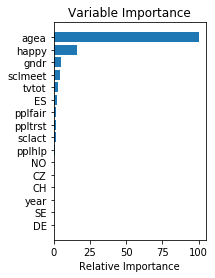

In [13]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

### Examine features

In [15]:
df.agea.value_counts()

54.0     168
46.0     166
42.0     159
48.0     155
52.0     155
        ... 
96.0       1
101.0      1
103.0      1
114.0      1
97.0       1
Name: agea, Length: 83, dtype: int64

In [17]:
df.happy.value_counts().sort_index()

0.0       22
1.0       21
2.0       55
3.0      118
4.0      166
5.0      560
6.0      580
7.0     1453
8.0     2424
9.0     1671
10.0    1077
Name: happy, dtype: int64

(12.0, 0.0)

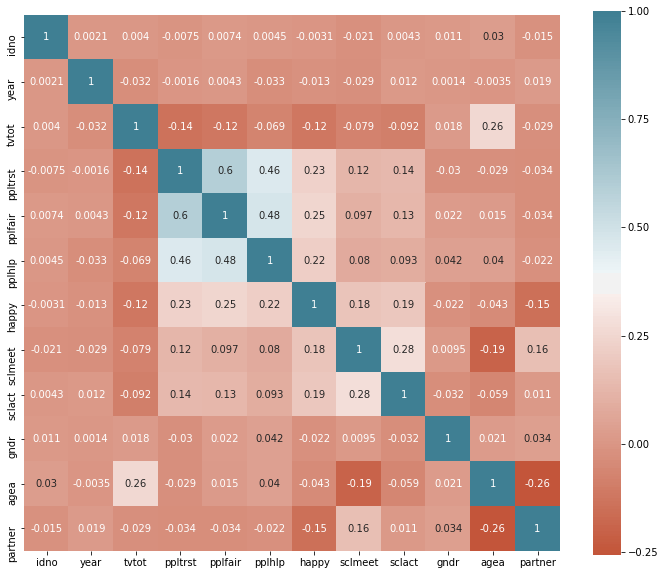

In [91]:
plt.figure(figsize=(12,10))
ax = sns.heatmap(df.corr(),
                     annot=True,
                     cmap=sns.diverging_palette(20, 220, n=200),
                     square=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ppltrst, pplfair, and pplhlp - these all seem to be correlated with each other, combining them might be beneficial, all of these are on a scale from 1 - 10

In [45]:
# copy data
df2 = df.copy()

# combine features identified above
df2['ppl_comb'] = df2[['ppltrst', 'pplfair', 'pplhlp']].sum(axis=1)/3

In [46]:
df2.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,ppl_comb
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0,6.000000
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0,5.666667
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0,8.000000
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0,6.333333
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0,6.000000


In [49]:
# drop features I have combined
df2.drop(['ppltrst', 'pplfair', 'pplhlp'], axis=1, inplace=True)

In [50]:
df2.head()

,cntry,idno,year,tvtot,happy,sclmeet,sclact,gndr,agea,partner,ppl_comb
0,CH,5.0,6,3.0,8.0,5.0,4.0,2.0,60.0,1.0,6.000000
1,CH,25.0,6,6.0,9.0,3.0,2.0,2.0,59.0,1.0,5.666667
2,CH,26.0,6,1.0,7.0,6.0,3.0,1.0,24.0,2.0,8.000000
3,CH,28.0,6,4.0,10.0,6.0,2.0,2.0,64.0,1.0,6.333333
4,CH,29.0,6,5.0,8.0,7.0,2.0,2.0,55.0,1.0,6.000000


In [52]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df2['partner'] - 1
X = df2.drop(['partner', 'cntry', 'idno'], axis=1)

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df2['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

### Model based on new features
adjust parameters - 200 iterations, tree depth set to 2

In [57]:
params = {'n_estimators': 200,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04487179487179487
Percent Type II errors: 0.1875340971085652

Test set accuracy:
Percent Type I errors: 0.05276073619631902
Percent Type II errors: 0.2


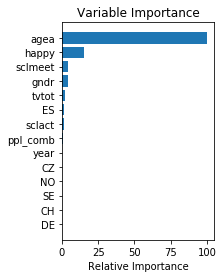

In [58]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Type I errors are very low, but Type II errors are very high.

### Adjust Parameters - 1
adjust parameters - 500 iterations, tree depth set to 2

In [55]:
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.047599563557010366
Percent Type II errors: 0.17757774140752863

Test set accuracy:
Percent Type I errors: 0.06012269938650307
Percent Type II errors: 0.18404907975460122


Type II errors come down, but at the expense of increasing Type I errors.

### Adjust Parameters - 2
adjust parameters - 1000 iterations, tree depth set to 4

In [53]:
params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.015002727768685215
Percent Type II errors: 0.09301691216584834

Test set accuracy:
Percent Type I errors: 0.09693251533742331
Percent Type II errors: 0.16809815950920245


Type I errors in the training set are smaller, however Type I errors in the test set are larger.  Similar for Type II errors.  Overall, this seems to be the best combination.

### Adjust Parameters - 2.1
adjust parameters - 1000 iterations, tree depth set to 4, subsample set to 0.5

In [65]:
params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'deviance',
         'subsample': .5,}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.01691216584833606
Percent Type II errors: 0.08769776322967812

Test set accuracy:
Percent Type I errors: 0.08957055214723926
Percent Type II errors: 0.17914110429447852


Type I errors were reduced, however Type II errors increased.

### Adjust Parameters - 2.2
adjust parameters - 1000 iterations, tree depth set to 4, subsample set to 0.5, learning rate set to .5

In [66]:
params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'deviance',
         'subsample': .5,
         'learning_rate': .5}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0721494817239498
Percent Type II errors: 0.09547190398254228

Test set accuracy:
Percent Type I errors: 0.07730061349693251
Percent Type II errors: 0.19386503067484662


similar to the above, Type I errors were reduced, however Type II errors increased.

### Adjust Parameters - 3
adjust parameters - 2000 iterations, tree depth set to 8

In [59]:
params = {'n_estimators': 2000,
          'max_depth': 8,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.00013638843426077467
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.10429447852760736
Percent Type II errors: 0.18036809815950922


Type I errors increase.

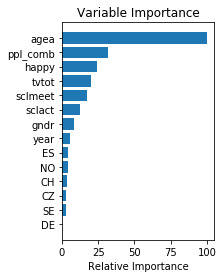

In [60]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Interestingly, the composite feature I created moves ahead of happiness in the ranking of variable importance.

### Adjust Parameters - Using Grid Search
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

The below took about 17 minutes to run.

In [86]:
param_test1 = {'n_estimators':range(500, 701, 50),
              'learning_rate': [0.05, 0.1],
              'max_depth': range(2, 10, 2),
              'subsample': [.2, .4, .6, .8]}

gsearch1 = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(
           max_features='sqrt',
           random_state=10), 
           param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_...=None,
                                                  presort='aut

In [89]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 1.01886358,  1.23409882,  1.21554813,  1.0525835 ,  1.18662648,
          1.54327254,  1.57458897,  1.46408343,  1.45091934,  1.6902782 ,
          1.72279224,  1.55663567,  1.54347219,  1.82451911,  2.25696378,
          2.19233637,  1.9017138 ,  1.91846824,  2.08901401,  2.03775229,
          2.19034247,  2.2994504 ,  2.28588738,  2.27331982,  2.09778938,
          2.35031328,  2.48375702,  2.48894362,  2.07365413,  2.46560454,
          2.63535323,  2.5800992 ,  2.24419513,  2.6122138 ,  2.78016372,
          2.8681284 ,  2.49353056,  3.12683802,  3.29877687,  3.27962976,
          3.33887119,  3.80961123,  3.96559539,  4.29192123,  4.22430291,
          4.34059095,  4.42775888,  4.63380761,  3.98075275,  4.46186733,
          5.03134418,  4.93420439,  4.23646965,  4.8787528 ,  5.30361605,
          5.58466463,  4.68706446,  6.02708154,  6.8572618 ,  7.68320951,
          8.11310253,  8.47832632,  9.58736072, 10.64592767,  8.854321  ,
         10.61680727,

In [90]:
# using the best results from above
# run the model
params = {'n_estimators': 500,
          'max_depth': 2,
          'subsample': 0.6,
          'learning_rate': 0.1,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.046235679214402615
Percent Type II errors: 0.17430441898527005

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


The results are only slightly better than what I achieved above with manual trial and error.